In [1]:
import sys
import os
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

# **SODA Implementation - Simulation**

If we run an experiment (see [intro_learning](./intro_learning.ipynb)) and store the results, we can compute several metric to evaluate these strategies. So first, let's just run an experiment and store the result. 

In [2]:
from soda.util.experiment import Experiment

In [3]:
param_logging = {
    "path_experiment": "../experiments/test/",
    "save_strategy": True,
    "save_strategy_init": False,
    "save_image": True,
    "round_decimal": 5,
}

config_game = "../configs/game/single_item/fpsb.yaml"
config_learner = "../configs/learner/sofw.yaml"

exp_handler = Experiment(
            config_game,
            config_learner,
            number_runs=5,
            label_experiment="fpsb",
            param_computation={"active": True, "init_method": "random"},
            param_simulation={"active": False},
            param_logging=param_logging,
        )


exp_handler.run()

---------------------------------------------------------------------------
 - game   : ../configs/game/single_item/fpsb.yaml
 - learner: ../configs/learner/sofw.yaml
 - Setting created 
 - Computation:
    own gradient computation is used


    Progress:   0%|                    | 0.00/5.00 [00:00<?, ?it/s]

    Progress: 100%|████████████████████| 5.00/5.00 [00:03<00:00, 1.53it/s]

---------------------------------------------------------------------------


## **Create Setting and import strategy**

To evaluate the strategies we have to create the setting and then import the saved strategies from the experiment above.

In [4]:
from soda.util.config import Config

In [5]:
config = Config(game_config, learner_config)
game, learner = config.create_setting()

NameError: name 'game_config' is not defined

Then we create the strategies and import the stored computed ones:

In [ ]:
# init strategies
strategies = config.create_strategies(game, init_method="nan")

# load saved strategies (name pattern is always learner_setting_run_x)
name = f"fpsb_sofw_run_0"
filename = os.path.join("../experiments/test/", experiment_tag, "strategies", name)
for i in strategies:
    strategies[i].load(filename)


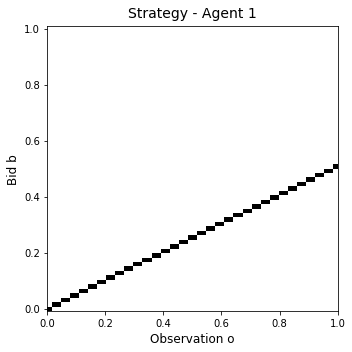

In [ ]:
strategies['1'].plot()

## **Sample Bids**

Since we want to evaluate the computed strategy in the original continuous mechanism, we sample bids for evaluation

In [ ]:
# sample 100 (continuous) observations for all agents
observation_profile = game.mechanism.sample_types(n_vals = 100)

# sample bids from strategy for first agent (index 0)
observations = observation_profile[0]
bids = strategies['1'].sample_bids(observation=observations)

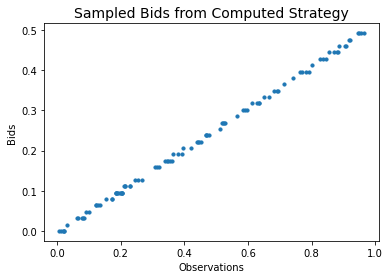

In [ ]:
plt.scatter(observations, bids, s = 10)
plt.title("Sampled Bids from Computed Strategy", fontsize=14)
plt.xlabel("Observations")
plt.ylabel("Bids")
plt.show()

We sample continuous observations, identify the nearest discrete observation and then sample discrete bids according to the computed strategy.
This is why we only get discrete actions.

### **Metrics**

One metric we often consider is the approximated L2 distance between the bids from the exact BNE $\beta$ and the bids from the computed strategy $s$

\begin{equation}
    L_2(s, \beta) = \left( \dfrac{1}{n_o} \sum_o ( \beta(o) - s(o))^2 \right)^{\frac 1 2}
\end{equation}

This means we sample many observations (types) and then compute the distance between the equilibrium bid, i.e., $\beta(o)$ and the bid sampled from the computed strategy s, i.e., $b \sim s(\cdot \vert o)$, given the observation o.

In [ ]:
obs_profile = game.mechanism.sample_types(n_vals = 10_000)
bid_profile = np.array([
    strategies[game.bidder[i]].sample_bids(obs_profile[i]) for i in range(game.n_bidder)
])

obs, bids = obs_profile[0], bid_profile[0]
game.mechanism.compute_l2_norm(agent='1', obs=obs, bids=bids)

0.008154591355775693

The second import metric is the relative utility loss, i.e., the relative loss in the utility if we play many auctions and use the computed strategy vs. the exact equilibrium strategies. The auctions are simulated by sampling observations and the corresping bids.

In [ ]:
util, util_in_bne, util_vs_bne, util_loss = game.mechanism.compute_utility_vs_bne(
    agent='1', obs_profile=obs_profile, bid_profile=bid_profile
    )


print(f"Utility if all agents play the computed   BNE: {util:.3f}")
print(f"                           the analytical BNE: {util_in_bne:.3f}")
print(f"Utility if agent 1 plays against analyt. BNE: {util_vs_bne:.3f}")
print(f"                       relative utility loss: {util_loss:.3f}")

Utility if all agents play the computed   BNE: 0.162
                           the analytical BNE: 0.169
Utility if agent 1 plays against analyt. BNE: 0.168
                       relative utility loss: 0.002


The last entry is the utility agent '1' would get, if the agent would use the equilibrium strategy $\beta$ ($U(\beta, \beta$). The second entry is the utility of agent '1' when using the computed strategy $s$ ($u)(s,\beta)$. In both cases the opponents play according to the exact equilibrium strategy $\beta$. The first entry denotes the relative difference in utility ($\mathcal L$) we get by not playing the exact BNE:

\begin{equation}
    \mathcal L(s, \beta) = \dfrac{u(\beta, \beta) - u(s, \beta)}{u(\beta, \beta)}
\end{equation}

Depending on the implented mechanism, other interesting metrics might be available, e.g., the average revenue of the auctioneer when agents play according to the computed strategies

In [ ]:
game.mechanism.revenue(bid_profile).mean()

0.3335603174603175